In [2]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from windrose import WindroseAxes
import requests
import datetime
import numpy as np
import csv
%matplotlib inline

In [3]:
def max_df(df):
    maxrrsd3 = df['sdfsw3d'].groupby(pd.Grouper(freq='Y')).max()  #3 døgns snømengde
    maxrr = df['rr'].groupby(pd.Grouper(freq='Y')).max()
    maxrr3 = df['rr3'].groupby(pd.Grouper(freq='Y')).max()
    maxsd = df['sd'].groupby(pd.Grouper(freq='Y')).max()
    maxrr_df = pd.concat ([maxrr, maxrr3, maxrrsd3, maxsd], axis=1)

    return maxrr_df

def plot_normaler(df, ax1=None):
    #Lager dataframe med månedsvise mengder av temperatur og nedbør GRAF1
    #df['month'] = pd.DatetimeIndex(df.index).month #Lager ei kolonne med månedsnummer

    mon_rr = df['rr'].groupby(pd.Grouper(freq='M')).sum() #Grupperer nedbør etter måneder per år og summerer
    mon_tm = df['tm'].groupby(pd.Grouper(freq='M')).mean() #Grupperer temperatur etter måneder per år og tar snitt
    month_rr = mon_rr.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
    month_tm = mon_tm.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
    month_rr['m'] = pd.DatetimeIndex(month_rr.index).month #lager kolonne for månedsnummer
    month_tm['m'] = pd.DatetimeIndex(month_tm.index).month #Lager kolonne for månedsnummer
    month_mean_tm = month_tm.groupby(['m']).mean()
    
    if ax1 is None:
        ax1 = plt.gca()
    ax1.set_title('Gjennomsnittlig månedsnedbør og temperatur ' + startdato[0:4] + ' til ' + sluttdato[0:4])
    ax1.bar(month_rr['m'], month_rr['rr'], width=0.5, snap=False)
    ax1.set_xlabel('Måned')
    ax1.set_ylabel('Nedbør (mm)')
    ax1.set_ylim(0, month_rr['rr'].max()+50)
    #ax1.text('1960', aar_df['rr'].max()+20, "Gjennomsnittlig månedsnedbør:  " + str(int(snitt)) + ' mm')

    ax2 = ax1.twinx()#Setter ny akse på høgre side 
    ax2.plot(month_mean_tm.index, month_mean_tm['tm'], 'r', label='Gjennomsnittstemperatur', linewidth=3.5)
    ax2.set_ylim(month_mean_tm['tm'].min()-2, month_mean_tm['tm'].max()+5)
    ax2.set_ylabel(u'Temperatur (\u00B0C)')
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.get_yaxis().set_visible(True)
    ax2.legend()

    return ax1, ax2

def plot_nedbor_normal(df, label, barid, width, color='g', hatch='', ax1=None):
    mon_rr = df['rr'].groupby(pd.Grouper(freq='M')).sum() #Grupperer nedbør etter måneder per år og summerer
    month_rr = mon_rr.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
    month_rr['m'] = pd.DatetimeIndex(month_rr.index).month #lager kolonne for månedsnummer
    
    if ax1 is None:
        ax1 = plt.gca()
    #ax1.set_title('Gjennomsnittlig månedsnedbør')
    ax1.bar(month_rr['m'] + barid, month_rr['rr'], width=width, snap=False, label=label, hatch=hatch, color=color)
    ax1.set_xlabel('Måned')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.set_ylabel('Nedbør (mm)')
    ax1.set_ylim(0, month_rr['rr'].max()+50)
    #ax1.text('1960', aar_df['rr'].max()+20, "Gjennomsnittlig månedsnedbør:  " + str(int(snitt)) + ' mm')
    ax1.legend()
    

def plot_temperatur(df, label, farge, linestyle, ax1=None):
    #Lager dataframe med månedsvise mengder av temperatur
    
    mon_tm = df['tm'].groupby(pd.Grouper(freq='M')).mean() #Grupperer temperatur etter måneder per år og tar snitt
    month_tm = mon_tm.to_frame() #Lager dataframe, unødvendig? Eklere å plotte?
    month_tm['m'] = pd.DatetimeIndex(month_tm.index).month #Lager kolonne for månedsnummer
    month_mean_tm = month_tm.groupby(['m']).mean()
    
    if ax1 is None:
        ax1 = plt.gca()

    ax1.plot(month_mean_tm.index, month_mean_tm['tm'], farge, label=label, linewidth=2, linestyle=linestyle)
    ax1.axhline(0, linestyle='--', color='grey', linewidth=0.5)
    ax1.set_ylim(month_mean_tm['tm'].min()-2, month_mean_tm['tm'].max()+5)
    ax1.set_ylabel(u'Temperatur (\u00B0C)')
    ax1.set_xlabel('Måned')
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.get_yaxis().set_visible(True)
    ax1.legend()

    return ax1

def plot_snomengde(df, ax1=None):
    dag = df['sd'].groupby(df.index.strftime('%m-%d')).mean()
    dag_sd_df = dag.to_frame()
    dagtm = df['tm'].groupby(df.index.strftime('%m-%d')).mean()
    dag_tm_df = dagtm.to_frame()
    dag_tm_df['tm_min'] = df['tm'].groupby(df.index.strftime('%m-%d')).min()
    dag_tm_df['tm_max'] = df['tm'].groupby(df.index.strftime('%m-%d')).max()
    dag_sd_df['sd_max'] = df['sd'].groupby(df.index.strftime('%m-%d')).max()
    dag_sd_df['sd_min'] = df['sd'].groupby(df.index.strftime('%m-%d')).min()

    if ax1 is None:
        ax1 = plt.gca()
    
    ax1.plot(dag_sd_df.index, dag_sd_df['sd'], label='Snitt snømengde')
    ax1.plot(dag_sd_df.index, dag_sd_df['sd_max'], label='Max snømengde')
    ax1.plot(dag_sd_df.index, dag_sd_df['sd_min'], label='Min snømengde')
    ax1.xaxis.set_major_locator(MultipleLocator(32))
    #ax1.xaxis.set_major_formatter(FormatStrFormatter('%m'))
    ax1.set_title('Snømengde  ' + startdato[0:4] + ' til ' + sluttdato[0:4])
    ax1.set_xlabel('Dag i året (måned-dag)')
    ax1.set_ylabel('Snøhøgde (cm)')
    ax1.legend()

    ax2 = ax1.twinx()
    ax2.plot(dag_tm_df.index, dag_tm_df['tm'], 'r--', label='Gjennomsnittstemperatur')
    ax2.xaxis.set_major_locator(MultipleLocator(32))
    ax2.legend(loc='lower left')
    ax2.set_ylim(dag_tm_df['tm'].min()-5, dag_tm_df['tm'].max()+5)
    ax2.axhline(0, linestyle='--', color='grey', linewidth=0.5)
    ax2.set_ylabel(u'Temperatur (\u00B0C)')

    return ax1, ax2

def plot_maks_snodjupne(df, barid, width, color='r', ax1=None):
    sno = df['sd'].groupby(pd.Grouper(freq='Y')).max() #Finner maksimal snødjupne per år
    sno_df = sno.to_frame() #Lager pandas series om til dataframe
    maxaar = sno_df.idxmax() #Finner året med maksimal snømengde
    snomax = sno_df.max() #Finner maksimal snømengde
   
    sno_df_6090 = sno_df.loc['1961':'1990']
    snosnitt_6090 = sno_df_6090 ['sd'].mean() #Finner snitt snømengd

    sno_df_9020 = sno_df.loc['1991':'2020']
    snosnitt_9020 = sno_df_9020['sd'].mean() #Finner snitt snømengd
    snosnitt = sno_df['sd'].mean() #Finner snitt snømengd
    sno_df['snitt'] = snosnitt #Lager kolonne med snittmengde for å plotte strek i graf
    maxstr = str(maxaar)[5:15] #Klipper til streng for å vise makspunkt i graf
    maxsno = str(snomax)[5:12] #Klipper til streng for å vise makspunkt i graf
    maksimal_snodato = df['sd'].idxmax().date() 
    maksimal_sno = df['sd'].max()
    anotstring = 'Maks snøhøgde: ' +str(maksimal_snodato) + ' | ' + str(maksimal_sno) + 'cm'
    
    sd_df_trend = sno_df.copy()
    sd_df_trend.index = sd_df_trend.index.map(datetime.date.toordinal)
    slope, y0, r, p, stderr = stats.linregress(sd_df_trend.index, sd_df_trend['sd'])
    x_endpoints = pd.DataFrame([sd_df_trend.index[0], sd_df_trend.index[-1]])
    y_endpoints = y0 + slope * x_endpoints
    if sno_df['sd'].min() - 60 < 0:
        snomin = 0
    else:
        snomin = sno_df['sd'].min() - 60

    if ax1 is None:
        ax1 = plt.gca()
    #ax1.set_title('Maksimal snødjupe fra ' + startdato[0:4] + ' til ' + sluttdato[0:4])
    ax1.bar(sno_df.index, sno_df['sd'], width=width, snap=False, color=color) 
    ax1.set_xlabel('Årstall')
    ax1.set_ylabel('Snødjupne (cm)')
    ax1.set_ylim(snomin, sno_df['sd'].max()+60)
    # ax1.annotate(anotstring, xy=(maksimal_snodato, maksimal_sno),  xycoords='data',
    #             xytext=(0.80, 0.95), textcoords='axes fraction',
    #             arrowprops=dict(arrowstyle="->"))

    ax2 = ax1.twinx()
    ax2.plot([sno_df.index[0], sno_df.index[-1]], [y_endpoints[0][0], y_endpoints[0][1]], linestyle='dashed', linewidth=1, color='r', label='Trend')
    #ax2.plot(sno_df.index, sno_df['snitt'], linewidth=1, linestyle='dashed', color='b', label='Snitt')
    ax2.hlines(y=snosnitt_6090, xmin='1961-01-01', xmax='1990-12-31', linestyle='dashed', linewidth=2, color='g', label='Snitt 1961-1990')
    ax2.hlines(y=snosnitt_9020, xmin='1990-01-01', xmax='2020-12-31', linestyle='dashed', linewidth=2, color='r', label='Snitt 1991-2020')
    ax2.set_ylim(snomin, sno_df['sd'].max()+60)
    ax2.get_yaxis().set_visible(False)
    #ax1.text(startdato[0:4], df['sd'].max()+20, "Gjennomsnittlig maksimal snødjupne (1991-2020):  " + str(int(snosnitt_9020)) + ' cm')
    ax2.legend(loc='best')
    
    return ax1, ax2

def plot_aarsnedbor(df, ax1=None):
    aar = df['rr'].groupby(pd.Grouper(freq='Y')).sum() #Summerer all nedbør iløpet av eit år
    aar_df = aar.to_frame() #Lager dataframe
    snitt = aar_df['rr'].mean() #Lager snitt av nedbør
    aar_df['snitt'] = snitt #Lager kolonne med snittverdi for plotting
    aar_df_6090 = aar_df.loc['1961':'1990']
    aarsnitt_6090 = aar_df_6090 ['rr'].mean() 
    aar_df_9020 = aar_df.loc['1991':'2020']
    aarsnitt_9020 = aar_df_9020['rr'].mean() 
    aar_df_trend = aar_df.copy()
    aar_df_trend.index = aar_df_trend.index.map(datetime.date.toordinal)
    slope, y0, r, p, stderr = stats.linregress(aar_df_trend.index, aar_df_trend['rr'])
    x_endpoints = pd.DataFrame([aar_df_trend.index[0], aar_df_trend.index[-1]])
    y_endpoints = y0 + slope * x_endpoints

    if ax1 is None:
        ax1 = plt.gca()

    ax1.set_title('Årsnedbør fra ' + startdato[0:4] + ' til ' + sluttdato[0:4])
    ax1.bar(aar_df.index,  aar_df['rr'], width=320, snap=False) #Width er litt vanseklig, dersom ei søyle har bredde 365 dekker den "heile bredden", det er det samme som eit år, da x-aksen er delt opp i år..
    ax1.set_xlabel('Årstall')
    ax1.set_ylabel('Nedbør (mm)')
    ax1.set_ylim(aar_df['rr'].min()-200, aar_df['rr'].max()+500)
    ax1.text(startdato[0:4], aar_df['rr'].max()+200, "Gjennomsnittlig årsnedbør (1991-2020):  " + str(int(aarsnitt_9020)) + ' mm')

    ax2 = ax1.twinx()
    ax2.plot([aar_df.index[0], aar_df.index[-1]], [y_endpoints[0][0], y_endpoints[0][1]], linestyle='dashed', linewidth=1, color='r', label='Trend')
    ax2.hlines(y=aarsnitt_6090, xmin='1961-01-01', xmax='1990-12-31', linestyle='dashed', linewidth=2, color='g', label='Snitt 1961-1990')
    ax2.hlines(y=aarsnitt_9020, xmin='1990-01-01', xmax='2020-12-31', linestyle='dashed', linewidth=2, color='r', label='Snitt 1991-2020')
    #ax2.plot(aar_df.index, aar_df['snitt'], linestyle='dotted', linewidth=1, color='r', label='Snitt 1958-2020')
    ax2.set_ylim(aar_df['rr'].min()-200, aar_df['rr'].max()+500)
    ax2.get_yaxis().set_visible(False)
    ax2.legend(loc='lower right')

    return ax1, ax2

def plot_3dsno(df, ax1=None):
    maxrrsd3 = df['sdfsw3d'].groupby(pd.Grouper(freq='Y')).max()  #3 døgns snømengde
    maxrr = df['rr'].groupby(pd.Grouper(freq='Y')).max()
    maxrr3 = df['rr3'].groupby(pd.Grouper(freq='Y')).max()
    maxrr_df = pd.concat ([maxrr, maxrr3, maxrrsd3], axis=1)
    maksimal_sdfsw3ddato = df['sdfsw3d'].idxmax().date()
    maksimal_sdfsw3d = df['sdfsw3d'].max()

    maks_3dsno_df_6090 = maxrr_df.loc['1961':'1990']
    max_3dsno_6090 = maks_3dsno_df_6090['sdfsw3d'].mean() #Finner snitt snømengd

    max_3dsno_df_9020 = maxrr_df.loc['1991':'2020']
    max_3dsno_9020 = max_3dsno_df_9020['sdfsw3d'].mean() #Finner snitt snømengd

    if ax1 is None:
        ax1 = plt.gca()

    ax1.set_title('Maksimal 3 døgns snømengde')
    ax1.bar(maxrr_df.index, maxrr_df['sdfsw3d'], width=320, snap=False, color='powderblue')
    ax1.hlines(y=max_3dsno_6090, xmin='1961-01-01', xmax='1990-12-31', linestyle='dashed', linewidth=2, color='g', label='Snitt 1961-1990')
    ax1.hlines(y=max_3dsno_9020, xmin='1990-01-01', xmax='2020-12-31', linestyle='dashed', linewidth=2, color='r', label='Snitt 1991-2020')
    ax1.set_xlabel('Årstall')
    ax1.set_ylabel('Maksimal årlig 3 døgns snømengde (mm)')
    ax1.set_ylim(0, maxrr_df['sdfsw3d'].max()+10)
    # ax1.annotate((str(maksimal_sdfsw3ddato) + ' | ' + str(maksimal_sdfsw3d) + ' mm'), xy=(maksimal_sdfsw3ddato, maksimal_sdfsw3d),  xycoords='data',
    #             xytext=(50, 0), textcoords='offset points',
    #             arrowprops=dict(arrowstyle="->"))
    ax1.text(startdato[0:4], df['sdfsw3d'].max(), 'Maksimalverdi: ' + str(maksimal_sdfsw3ddato) + ' | ' + str(maksimal_sdfsw3d) + ' mm' )
    ax1.legend(loc='best')
    return ax1

def plot_maks_dognnedbor(df, ax1=None):
    maxrrsd3 = df['sdfsw3d'].groupby(pd.Grouper(freq='Y')).max()  #3 døgns snømengde
    maxrr = df['rr'].groupby(pd.Grouper(freq='Y')).max()
    maxrr3 = df['rr3'].groupby(pd.Grouper(freq='Y')).max()
    maxrr_df = pd.concat ([maxrr, maxrr3, maxrrsd3], axis=1)
    maksimal_rrdato = df['rr'].idxmax().date()
    maksimal_rr = df['rr'].max()

    if ax1 is None:
        ax1 = plt.gca()

    ax1.set_title('Maksimal døgnnedbør')
    ax1.bar(maxrr_df.index, maxrr_df['rr'], width=320, snap=False)
    ax1.set_xlabel('Årstall')
    ax1.set_ylabel('Maksimal årlig døgnnedbør (mm)')
    ax1.set_ylim(0, maxrr_df['rr'].max()+10)
    ax1.text(startdato[0:4], df['rr'].max(), 'Maksimalverdi: ' + str(maksimal_rrdato) + ' | ' + str(maksimal_rr) + ' mm')
    # ax1.annotate((str(maksimal_rrdato) + ' | ' + str(maksimal_rr) + ' mm'), xy=(maksimal_rrdato, maksimal_rr),  xycoords='data',
    #             xytext=(-150, 0), textcoords='offset points',
    #             arrowprops=dict(arrowstyle="->"))

    return ax1

def plot_vind(dfw, dfwx, dfwxrr):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw=dict(projection='windrose'), figsize=(20,20))
    
    ax1.bar(dfwx['retning'], dfwx['windSpeed10m24h06'], normed=True, opening=1.8)
    ax1.set_title('Antall dager med gitt vindretning')
    #ax1.legend(title='Vindstyrke (m/s')
    ax1.set_legend(title='Vindstyrke (m/s)')

    ax2.bar(dfwxrr['retning'], dfwxrr['rr'], normed=True, opening=1.8)
    ax2.set_title('Antall dager med gitt vindretning ved nedbør ')
    ax2.set_legend(title='Nedbør (mm)')

    ax3.bar(dfw['retning'], dfw['rr'], normed=True,opening=1.8)
    ax3.set_title('Antall dager med gitt vindretning ved nedbør som snø', )
    ax3.set_legend(title='Snø (mm)')

    return fig




In [4]:
klimapunkter = [
    ['Hoemstinden', 6957846, 97865],
    ['Storhaugen', 6965858, 83674],
    ['Steinhaugen', 6956308, 95853],
    ['Rekdalshesten', 6971911, 76202],
    ['Rekdal', 6973843, 78145]
]

In [5]:
'''
plotlist = []
for index,klimapunkt in enumerate(klimapunkter):
    df_rekdal = pd.read_csv("Rekdal_klimadata.csv")
    df_rekdal['dato'] =  pd.to_datetime(df_rekdal['dato'], format='%Y-%m-%d')
    df_rekdal.set_index('dato', inplace=True)
    with open('Rekdal_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_rekdal = row[0]
'''    

'\nplotlist = []\nfor index,klimapunkt in enumerate(klimapunkter):\n    df_rekdal = pd.read_csv("Rekdal_klimadata.csv")\n    df_rekdal[\'dato\'] =  pd.to_datetime(df_rekdal[\'dato\'], format=\'%Y-%m-%d\')\n    df_rekdal.set_index(\'dato\', inplace=True)\n    with open(\'Rekdal_høgde.csv\') as csvfile:\n    reader = csv.reader(csvfile)\n    for row in reader:\n        altitude_rekdal = row[0]\n'

In [6]:
df_rekdal = pd.read_csv("Rekdal_klimadata.csv")
df_rekdal['dato'] =  pd.to_datetime(df_rekdal['dato'], format='%Y-%m-%d')
df_rekdal.set_index('dato', inplace=True)
with open('Rekdal_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_rekdal = row[0]

df_steinhaugen = pd.read_csv("Steinhaugen_klimadata.csv")
df_steinhaugen['dato'] =  pd.to_datetime(df_steinhaugen['dato'], format='%Y-%m-%d')
df_steinhaugen.set_index('dato', inplace=True)
with open('Steinhaugen_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_steinhaugen = row[0]

df_Rekdalshesten = pd.read_csv("Rekdalshesten_klimadata.csv")
df_Rekdalshesten['dato'] =  pd.to_datetime(df_Rekdalshesten['dato'], format='%Y-%m-%d')
df_Rekdalshesten.set_index('dato', inplace=True)
with open('Rekdalshesten_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_rekdalshesten = row[0]
        
df_storhaugen = pd.read_csv("Storhaugen_klimadata.csv")
df_storhaugen['dato'] =  pd.to_datetime(df_storhaugen['dato'], format='%Y-%m-%d')
df_storhaugen.set_index('dato', inplace=True)
with open('Storhaugen_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_storhaugen = row[0]
        
df_hoemstinden = pd.read_csv("Hoemstinden_klimadata.csv")
df_hoemstinden['dato'] =  pd.to_datetime(df_hoemstinden['dato'], format='%Y-%m-%d')
df_hoemstinden.set_index('dato', inplace=True)
with open('Hoemstinden_høgde.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        altitude_hoemstinden = row[0]

In [7]:
df_rekdal

,rr,fsw,sd,sdfsw3d,tm,rr3
dato,,,,,,
1958-01-01,0.7,0,11.0,11.8,-2.85,NaN
1958-01-02,0.0,0,10.7,11.8,-6.75,NaN
1958-01-03,7.6,8,17.6,8.8,-5.55,8.300000e+00
1958-01-04,0.0,0,16.5,8.3,-2.85,7.600000e+00
1958-01-05,0.0,0,15.6,8.3,-0.65,7.600000e+00
...,...,...,...,...,...,...
2020-12-27,0.0,0,0.0,0.0,5.55,1.030000e+01
2020-12-28,0.0,0,0.0,0.0,7.45,9.000000e-01
2020-12-29,0.0,0,0.0,0.0,4.05,3.342882e-13


In [8]:
df_rekdal_9020 = df_rekdal.loc['1991':'2020']

In [9]:
df_rekdal_9020

,rr,fsw,sd,sdfsw3d,tm,rr3
dato,,,,,,
1991-01-01,0.0,0,0.0,0.0,-0.25,4.200000e+00
1991-01-02,0.0,0,0.0,0.0,2.35,1.376677e-13
1991-01-03,7.5,0,0.0,0.0,4.45,7.500000e+00
1991-01-04,0.4,0,0.0,0.0,4.25,7.900000e+00
1991-01-05,1.0,0,0.0,0.0,4.25,8.900000e+00
...,...,...,...,...,...,...
2020-12-27,0.0,0,0.0,0.0,5.55,1.030000e+01
2020-12-28,0.0,0,0.0,0.0,7.45,9.000000e-01
2020-12-29,0.0,0,0.0,0.0,4.05,3.342882e-13


In [10]:
label_generell = 'Høgde: '

(-7.0, 15.0)

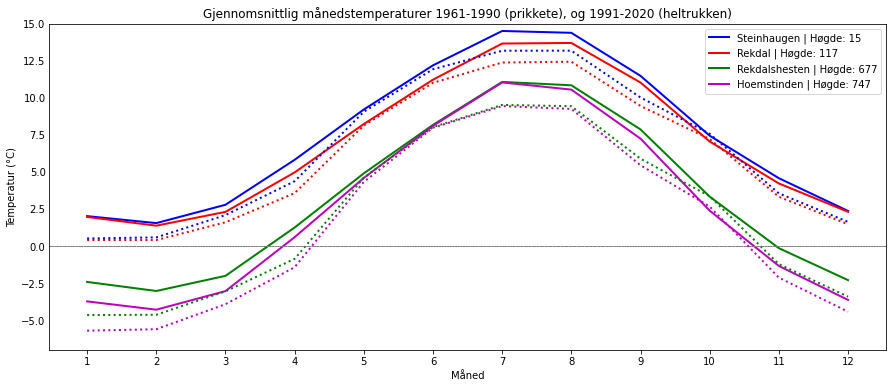

In [11]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Gjennomsnittlig månedstemperaturer 1961-1990 (prikkete), og 1991-2020 (heltrukken)')
ax1 = plot_temperatur(df_steinhaugen.loc['1991':'2020'], 'Steinhaugen | ' + label_generell + str(altitude_steinhaugen), 'b', linestyle='solid')
ax2 = plot_temperatur(df_rekdal.loc['1991':'2020'], 'Rekdal | ' + label_generell + str(altitude_rekdal), 'r', linestyle='solid')
ax3 = plot_temperatur(df_Rekdalshesten.loc['1991':'2020'], 'Rekdalshesten | ' + label_generell + str(altitude_rekdalshesten), 'g', linestyle='solid')
#ax4 = plot_temperatur(df_storhaugen.loc['1991':'2020'], 'Storhaugen | ' + label_generell + str(altitude_storhaugen), 'c', linestyle='solid')
ax5 = plot_temperatur(df_hoemstinden.loc['1991':'2020'], 'Hoemstinden | ' + label_generell + str(altitude_hoemstinden), 'm', linestyle='solid')
ax7 = plot_temperatur(df_rekdal.loc['1961':'1990'], '', 'r', linestyle='dotted')
ax8 = plot_temperatur(df_steinhaugen.loc['1961':'1990'], '', 'b', linestyle='dotted')
ax9 = plot_temperatur(df_Rekdalshesten.loc['1961':'1990'], '', 'g', linestyle='dotted')
#ax10 = plot_temperatur(df_storhaugen.loc['1961':'1990'], '', 'c', linestyle='dotted')
ax11 = plot_temperatur(df_hoemstinden.loc['1961':'1990'], '', 'm', linestyle='dotted')
ax1.set_ylim(-7, 15)

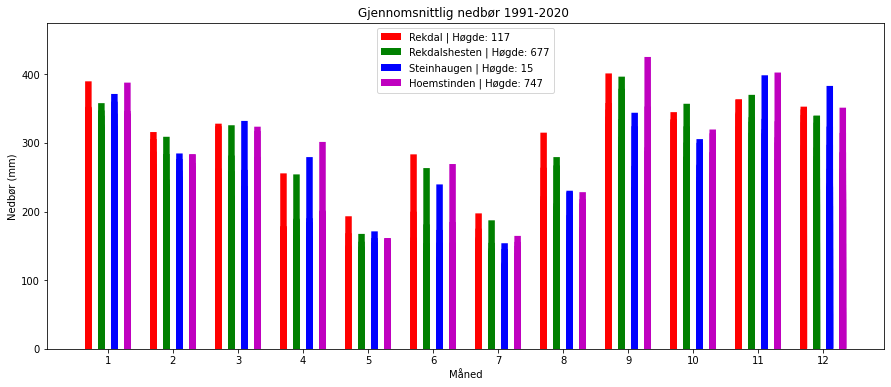

In [12]:
width_bar = 0.1
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Gjennomsnittlig nedbør 1991-2020 ')
ax1 = plot_nedbor_normal(df_rekdal.loc['1991':'2020'], 'Rekdal | ' + label_generell + str(altitude_rekdal),barid=-0.30, width=width_bar, color='r')
ax2 = plot_nedbor_normal(df_Rekdalshesten.loc['1991':'2020'], 'Rekdalshesten | ' + label_generell + str(altitude_rekdalshesten), barid=-0.10, width=width_bar, color='g')
#ax3 = plot_nedbor_normal(df_storhaugen.loc['1991':'2020'], 'Storhaugen | ' + label_generell + str(altitude_storhaugen), barid=0, width=width_bar, color='c')
ax4 = plot_nedbor_normal(df_steinhaugen.loc['1991':'2020'], 'Steinhaugen | ' + label_generell + str(altitude_steinhaugen), barid=0.10, width=width_bar, color='b')
ax5 = plot_nedbor_normal(df_hoemstinden.loc['1991':'2020'], 'Hoemstinden | ' + label_generell + str(altitude_hoemstinden), barid=0.30, width=width_bar, color='m')

# ax6 = plot_nedbor_normal(df_rekdal.loc['1961':'1990'], 'Rekdal | ' + label_generell + str(altitude_rekdal),barid=-0.25, hatch='/', width=width_bar, color='r')
# ax7 = plot_nedbor_normal(df_Rekdalshesten.loc['1961':'1990'], 'Rekdalshesten | ' + label_generell + str(altitude_rekdalshesten), hatch='/', barid=0.05, width=width_bar, color='g')
# #ax8 = plot_nedbor_normal(df_storhaugen.loc['1961':'1990'], 'Storhaugen | ' + label_generell + str(altitude_storhaugen), barid=0, hatch='/', width=width_bar, color='c')
# ax9 = plot_nedbor_normal(df_steinhaugen.loc['1961':'1990'], 'Steinhaugen | ' + label_generell + str(altitude_steinhaugen), barid=0.35, hatch='/', width=width_bar, color='b')
# ax10 = plot_nedbor_normal(df_hoemstinden.loc['1961':'1990'], 'Hoemstinden | ' + label_generell + str(altitude_hoemstinden), barid=0.65, hatch='/', width=width_bar, color='m')
 

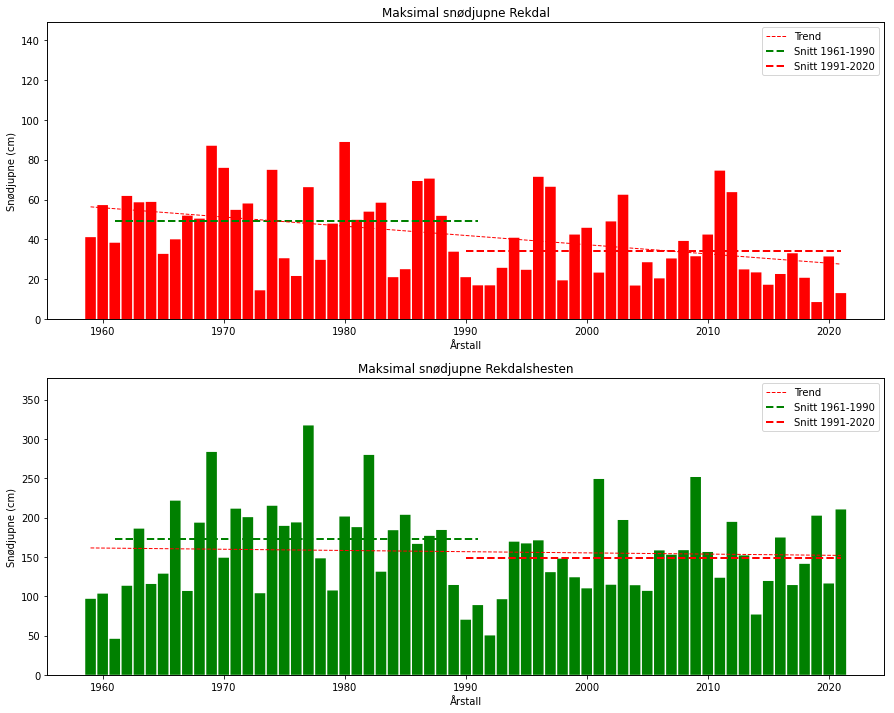

In [19]:
width_bar = 320
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.set_title('Maksimal snødjupne Rekdal')
ax1 = plot_maks_snodjupne(df_rekdal, 'Rekdal | ' + label_generell + str(altitude_rekdal), width=width_bar, color='r')
ax2 = fig.add_subplot(212)
ax2.set_title('Maksimal snødjupne Rekdalshesten')
ax2 = plot_maks_snodjupne(df_Rekdalshesten, 'Rekdalshesten | ' + label_generell + str(altitude_rekdalshesten), width=width_bar, color='g')
#ax3 = plot_nedbor_normal(df_storhaugen.loc['1991':'2020'], 'Storhaugen | ' + label_generell + str(altitude_storhaugen), barid=0, width=width_bar, color='c')
#ax4 = plot_nedbor_normal(df_steinhaugen.loc['1991':'2020'], 'Steinhaugen | ' + label_generell + str(altitude_steinhaugen), barid=0.10, width=width_bar, color='b')
#ax5 = plot_nedbor_normal(df_hoemstinden.loc['1991':'2020'], 'Hoemstinden | ' + label_generell + str(altitude_hoemstinden), barid=0.30, width=width_bar, color='m')


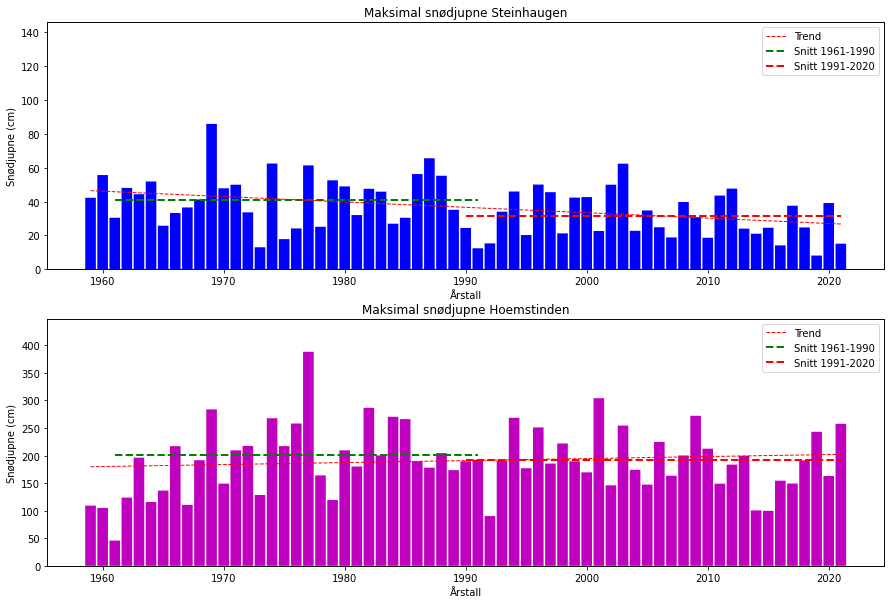

In [20]:
width_bar = 320
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1.set_title('Maksimal snødjupne Steinhaugen')
ax1 = plot_maks_snodjupne(df_steinhaugen, 'Steinhaugen | ' + label_generell + str(altitude_rekdal), width=width_bar, color='b')
ax2 = fig.add_subplot(212)
ax2.set_title('Maksimal snødjupne Hoemstinden')
ax2 = plot_maks_snodjupne(df_hoemstinden, 'Hoemstinden | ' + label_generell + str(altitude_rekdalshesten), width=width_bar, color='m')